In [1]:
#구현 흐름
"""
1. Dataset Pre-processing/Post-processing + define network input/output
2. Create Dataset
3. Create DataLoader
4. Create Network Model
5. Forward
6. Loss function
7. Optimisation
8. Train/Validation
9. Inference
"""

'\n1. Dataset Pre-processing/Post-processing + define network input/output\n2. Create Dataset\n3. Create DataLoader\n4. Create Network Model\n5. Forward\n6. Loss function\n7. Optimisation\n8. Train/Validation\n9. Inference\n'

In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
#1. Pre-processing
#resize: keep ratio, modify short side
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train":transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.6, 1.0)), #lower and upper bounds in ratio unit
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val":transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase="train"):
        return self.data_transform[phase](img)

In [3]:
imgFilePath = "./data/goldenretriever.jpg"
img = Image.open(imgFilePath)

print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x426 at 0x15315C640>


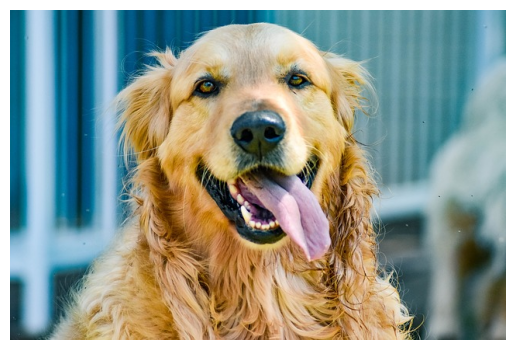

In [4]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
imageTransformed = transform(img, phase="train") #torch.size([3, 224, 224])

#PIL (c, h, w) --> torchTensor (h, w, c)
imageTransformed = imageTransformed.numpy().transpose((1, 2, 0))
imageTransformed = np.clip(imageTransformed, 0, 1)

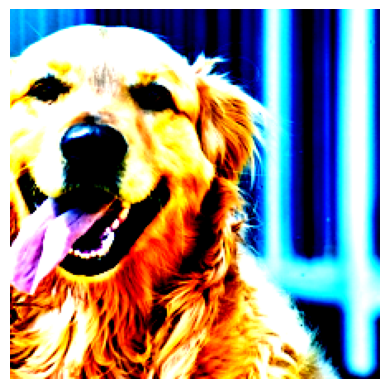

In [6]:
plt.imshow(imageTransformed)
plt.axis("off")
plt.show()

In [7]:
#train/val 경로 list return
def make_datapath_list(phase="train"):
    rootPath = "./data/hymenoptera_data/"
    targetPath = osp.join(rootPath + phase + "/**/*.jpg")
    print(targetPath)

    pathList = []
    for path in glob.glob(targetPath):
        pathList.append(path)

    return pathList

In [8]:
trainList = make_datapath_list(phase="train")
valList = make_datapath_list(phase="val")

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


In [9]:
print(trainList[:6])
print(valList[:6])

['./data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg', './data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg', './data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg', './data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg', './data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg', './data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg']
['./data/hymenoptera_data/val/bees/2717418782_bd83307d9f.jpg', './data/hymenoptera_data/val/bees/2173503984_9c6aaaa7e2.jpg', './data/hymenoptera_data/val/bees/54736755_c057723f64.jpg', './data/hymenoptera_data/val/bees/2103637821_8d26ee6b90.jpg', './data/hymenoptera_data/val/bees/603711658_4c8cd2201e.jpg', './data/hymenoptera_data/val/bees/238161922_55fa9a76ae.jpg']


In [10]:
#dataset
#필수 overriding methods: init, len, getitem(idx) 
class HymenopteraDataset(data.Dataset):
    def __init__(self, fileList:list, transform=None, phase="train"):
        self.fileList = fileList
        self.transform = transform #ImageTransform object
        self.phase = phase
    
    def __len__(self):
        return len(self.fileList)
    
    def __getitem__(self, index) -> torch.Tensor:
        imgPath = self.fileList[index]
        img = Image.open(imgPath) #

        imgTransformed = self.transform(img, self.phase)
        
        label = imgPath.split('/')[-2]
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        else:
            pass

        return imgTransformed, label

In [11]:
train_dataset = HymenopteraDataset(
    fileList=trainList, transform=ImageTransform(size, mean, std), phase="train"
)

val_dataset = HymenopteraDataset(
    fileList=valList, transform=ImageTransform(size, mean, std), phase="val"
)

In [12]:
idx = random.randint(0, len(train_dataset))
print(idx)
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])

199
torch.Size([3, 224, 224])
0


In [13]:
batchSize = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchSize, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batchSize, shuffle=False
)

dataloaders_dict = {
    "train": train_dataloader,
    "val": val_dataloader
}

In [14]:
#load batch amount of data
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(
    batch_iterator
)

print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1])


In [15]:
#Network Model
use_pretrained = torchvision.models.VGG16_Weights.DEFAULT
net = models.vgg16(weights=use_pretrained)

In [16]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
net.classifier[6] = nn.Linear(in_features=4096, out_features=2) #out 1000 --> 2
net.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [18]:
net.train() #train mode activated

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
criterion  = nn.CrossEntropyLoss()

In [20]:
#optimisation
params_to_update = []
update_params_names = ["classifier.6.weight", "classifier.6.bias"] #6th layer weight and bias

In [21]:
#only train 6th (last) layer in classifier
for name, param in net.named_parameters():
    if name in update_params_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
print(params_to_update)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[-0.0149,  0.0108,  0.0114,  ...,  0.0127, -0.0115,  0.0080],
        [ 0.0114, -0.0050,  0.0119,  ..., -0.0091,  0.0044,  0.0013]],
       requires_grad=True), Parameter containing:
tensor([0.0018, 0.0145], requires_grad=True)]


In [22]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [23]:
#train
from tqdm import tqdm
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ["train", "val"]:
            if phase == "train":
                net.train() #train mode
            else:
                net.eval() #validation mode

            epoch_loss = 0.0
            epoch_corrects = 0

            """if (epoch == 0) and (phase == "train"):
                #to check original performance
                continue"""

            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() #reset optimizer
                
                #def __init__(self, mode: bool) -> None:
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) #get loss
                    _, preds = torch.max(outputs, 1) 
                    #preds = outputs.argmax(1)
                    if phase == "train": 
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            print(f"{epoch}, Loss: {epoch_loss:.4f}, Acc: {epoch_corrects.double()/len(dataloaders_dict[phase].dataset)}")


In [24]:
num_epoch = 5
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epoch)

Epoch 1/5


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


0, Loss: 103.5603, Acc: 0.8024691358024691


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0, Loss: 26.5725, Acc: 0.954248366013072
Epoch 2/5


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


1, Loss: 33.9737, Acc: 0.9382716049382716


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


1, Loss: 19.4633, Acc: 0.954248366013072
Epoch 3/5


100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


2, Loss: 32.0517, Acc: 0.9506172839506173


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


2, Loss: 17.4586, Acc: 0.9477124183006536
Epoch 4/5


100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


3, Loss: 19.7561, Acc: 0.9711934156378601


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


3, Loss: 15.9701, Acc: 0.9477124183006536
Epoch 5/5


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


4, Loss: 20.1960, Acc: 0.9711934156378601


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]

4, Loss: 15.0814, Acc: 0.9477124183006536


In [193]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.0.1
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-12.6-arm64-arm-64bit
